# Kalman Covariance Matrices

This notebook aims at evaluating whether the following theoretical formulation for the **observation noise covariance** matrix holds in practice:
$$
\newcommand{\Var}[1]{\mathrm{Var}\left\{#1\right\}}
\newcommand{\Cov}[1]{\mathrm{Cov}\left\{#1\right\}}
\mathbf{R} =
  \left[
  \begin{array}{cc}
    \frac{\Var{\delta_{ms}} + \Var{\delta_{sm}}}{4} &  \frac{\Var{\delta_{ms}}}{2NT}\\
     \frac{\Var{\delta_{ms}}}{2NT} &  \frac{2\Var{\delta_{ms}}}{(NT)^2}\\
  \end{array}\right].
$$

We will assume the most generic scenario where:

- The minimum delay is asymmetric between m-to-s and s-to-m directions.
- The queueing delay is also asymmetric.

In other words, we will assume that both the mean and the variance of the m-to-s and s-to-m delays are asymmetric. Nevertheless, from the above formulation, note that only the variance impacts the noise covariance matrix. Thus, the asymmetry in the minimum delay makes no difference.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Even though the above formulation is generic for any distribution, we will assume a specific distribution. This will allow us to compute theoretical variances. Also, we will need to choose a distribution when generating delays anyways.

We will assume that m-to-s and s-to-m delays are Gamma distributed, with independent shape and scale parameters. Their variance will therefore be equal to `shape * (scale**2)`. Also, they will be generated with `np.random.gamma`. 

In [2]:
shape_m2s = 9
scale_m2s = 2000
shape_s2m = 8
scale_s2m = 1000
min_d_m2s = 10e3  
min_d_s2m = 15e3

# Theoretical variances:
var_d_ms  = shape_m2s*(scale_m2s**2)
var_d_sm  = shape_s2m*(scale_s2m**2)

Define the number of samples. This will control how close our empirical covariance approaches the theoretical one:

In [3]:
n_samples = int(1e6)

Generate independent m-to-s and s-to-m delays.

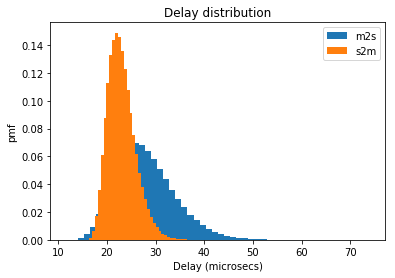

In [4]:
d_m2s = min_d_m2s + np.random.gamma(shape=shape_m2s, scale=scale_m2s, size=(n_samples, 1))
d_s2m = min_d_s2m + np.random.gamma(shape=shape_s2m, scale=scale_s2m, size=(n_samples, 1))

plt.figure()
plt.hist(d_m2s*1e-3, bins=50, density=True, label="m2s")
plt.hist(d_s2m*1e-3, bins=50, density=True, label="s2m")
plt.legend()
plt.xlabel("Delay (microsecs)")
plt.ylabel("pmf")
plt.title("Delay distribution")
plt.show()

Compute the noise that affects time and frequency offset measurements:

In [5]:
# Time offset measurement noise:
z_x = (d_m2s + d_s2m)/2

For the frequency offset measurement, we will need to generate a vector of Sync departure timestamps ($t_1$). For the purposes of this notebook, this will be an ideal vector, with evenly spaced departures (every $T$ seconds):

In [6]:
T  = 1.0/4
t1 = np.arange(0, n_samples).reshape(n_samples,1) * T

Using them, we can compute the frequency offset measurement noise due to PDV on m-to-s Sync messages:

$$ z_y[n] = \frac{\delta_{ms}[n] - \delta_{ms}[n-N]}{NT} $$

In [7]:
# Frequency offset measurement noise:
N   = 64 # observation window
dx  = d_m2s[N:] - d_m2s[:-N]
dt1 = t1[N:] - t1[:-N]
z_y = dx / dt1

Note that frequency offset measurements are window-based, hence they only exist after the first $N$ samples. To ensure that $z_x$ and $z_y$ vectors have the same length, we will throw away the initial $N$ samples from $z_x$:

In [8]:
z_x = z_x[N:]

Now, evaluate the covariance matrix $Cov(z_x, z_y)$:

In [9]:
X = np.stack((z_x, z_y), axis=0)
R = np.cov(np.squeeze(X))

And compute the theoretical measurement covariance matrix:

In [10]:
var_zx   = (var_d_ms + var_d_sm) / 4
cov_zxzy = var_d_ms / (2 * N * T)
var_zy   = (2 * var_d_ms) / (N*T)**2
R_theo   = np.array([[var_zx, cov_zxzy], [cov_zxzy, var_zy]])

Compare with the empirical covariance matrix with the theoretical one:

In [11]:
print("Empirical:")
print(R)
print("\nTheoretical:")
print(R_theo)
print("\nError:")
print((R - R_theo))
print("\nNormalized 2-norm of the error:", np.linalg.norm(R - R_theo)/np.linalg.norm(R_theo))

Empirical:
[[10979763.2150759   1124672.35470519]
 [ 1124672.35470519   281286.19572057]]

Theoretical:
[[11000000.  1125000.]
 [ 1125000.   281250.]]

Error:
[[-20236.7849241    -327.64529481]
 [  -327.64529481     36.19572057]]

Normalized 2-norm of the error: 0.0018206589629168395


So the theoretical formulation seems reasonable. In a more practical scenario, however, we can expect some disturbances. The two main ones are:

1. Sync departures are not evenly spaced. This means that the frequency offset measurement noise formulated as $ z_y[n] = \frac{\delta_{ms}[n] - \delta_{ms}[n-N]}{NT}$ won't perfectly match in reality. Nevertheless, as the observation interval $N$ grows, the approximation improves, since the individual fluctuations in inter-departure interval exert less influence.

2. The noise affecting time and frequency offset measurements isn't only due to delay as considered. There is also the noise that affects the timestamps themselves, namely due to timestamp granularity and phase noise. However, these are expected to be much lower in magnitude and therefore are ignored in the above formulation. This is especially neglectable for frequency offset measurement due to its computation that divides timestamps by a large interval $NT$, which attenuates the timestamp noise.